## LAB 5: SENTIMENT ANALYSIS 

**<font color=green>INSTRUCTIONS:</font>** <br> <br>
    **<font color=green>1. Look for EXERCISES and QUESTIONS in this script. </font>** <br> <br>
    **<font color=green>2. Each student INDIVIDUALLY uploads this script with their answers embedded to Canvas.</font>** <br>

### Objectives

1. Learn how to perform lexicon-based (unsupervised machine learning) sentiment analysis.
2. Fine-tune a lexicon-based sentiment analyzer.
2. Train your own sentiment classifier.

### Session Prep

In [1]:
#packages needed

#ignore warnings about future changes in functions as they take too much space
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

#the module 'sys' allows istalling module from inside Jupyter
import sys

!{sys.executable} -m pip install numpy
import numpy as np 

!{sys.executable} -m pip install pandas
import pandas as pd

#Natrual Language ToolKit (NLTK)
!{sys.executable} -m pip install nltk
import nltk

#text normalization function
%run ./Text_Normalization_Function.ipynb

#ignore warnings about future changes in functions as they take too much space
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /Users/lilia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lilia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lilia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/lilia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original:   <p>The circus dog in a plissé skirt jumped over Python who wasn't that large, just 3 feet long.</p>
Processed:  ['<', 'p', '>', 'The', 'circus', 'dog', 'in', 'a', 'plissé', 'skirt', 'jumped', 'over', 'Python', 'who', 'was', "n't", 'that', 'large', ',', 'just', '3', 'feet', 'long.', '<', '/p', '>']
Original:   <p>The circus dog in a plissé skirt jumped over Python who wasn't that large, just 3 feet long.</p>
Processed:  <p>The circus dog in a plissé skirt jumped over Python who was not that large, just 3 feet long.</p>
Original:   <p>The circus dog in a plissé skirt jumped over Python who wasn't that large, just 3 feet long.</p>
Processed:  [('<', 'a'), ('p', 'n'), ('>', 'v'), ('the', None), ('circus', 'n'), ('dog', 'n'), ('in', None), ('a', None), ('plissé', 'n'), ('skirt', 'n'), ('jumped', 'v'), ('over', None), ('python', 'n'), ('who', None), ('was', 'v'), ("n't", 'r'), ('that', None), ('large', 'a'), (',', None), ('just', 'r'), ('3', None), ('feet', 'n'), ('long.', 'a'), 

### Dataset

We will use movie reviews data. The movie reviews' polarity are labeled by humans into **positive** or **negative**. The data are divided into **training** (1,000 reviews) and **test** datasets (1,000 reviews). 

The data are stored in two **"pickled"** pandas dataframes, one for training data and one for test data. *Pickling* allows you to save a Python data object as a file on your hard drive. After you pickle your object, you can close your python session, restart your computer if you want, and load your object into a Python session. It's a very convenient approach for many situations. For example, you can use **pickling** if your raw data needed extensive cleaning and you do not want to repeat the cleaning operations every time you load the raw data. Check out the **pickling** package here: https://bit.ly/3cuEvBd.

**To get the data**:

1. Download the two files (mreviews_train.pkl and mreviews_test.pkl) to your machine from the Assignment on Canvas.

2. Set the path below to the folder on your machine where you put the data files (change the path shown).

**Important:** If you work on Jupyter.org/try then set the path as follows: path = ''. Also, remember to upload the text normalization function and data files to the cloud.

In [2]:
path = '/Users/lilia/Desktop/21FL/Text Mining/module5/'

Load the movie reviews data:

In [3]:
import pickle 

test_data = pd.read_pickle(path + 'mreviews_test.pkl')
train_data = pd.read_pickle(path + 'mreviews_train.pkl')

print("Dimensions for test data:", test_data.shape)
print("Dimensions for training data:", train_data.shape,"\n")
print("First 5 rows in test dataset: \n", test_data.head(),"\n")
print("First 5 rows in  training dataset: \n", train_data.head())

Dimensions for test data: (1000, 3)
Dimensions for training data: (1000, 3) 

First 5 rows in test dataset: 
     file_name                                        review_text  polarity
0    0_10.txt  I went and saw this movie last night after bei...  positive
0  100_10.txt  The finest short I've ever seen. Some commenta...  positive
0   101_9.txt  This is a very, very odd film...one that is so...  positive
0   102_8.txt  Although Bullet In The Brain is, without quest...  positive
0  103_10.txt  ...means "take up and read", which is precisel...  positive 

First 5 rows in  training dataset: 
     file_name                                        review_text  polarity
0     0_9.txt  Bromwell High is a cartoon comedy. It ran at t...  positive
0   100_7.txt  Scott Bartlett's 'OffOn' is nine minutes of pu...  positive
0   101_8.txt  IMDb lists this as 1972 for some reason, but t...  positive
0  102_10.txt  I first heard about this film about 20 years a...  positive
0   103_7.txt  when i read

Each dataframe consists of **3 columns**: 

- **file_name** (the name of the file with review text), 
- **review_text** (the text of the review), 
- **polarity** (label for binary sentiment polarity created by a human: positive or negative). 

Let's split the training and testing dataframes into two dataframes each **..._reviews** and **..._polarity**, consisting of the respective columns:

In [4]:
test_reviews = np.array(test_data['review_text'])
test_polarity = np.array(test_data['polarity'])

train_reviews = np.array(train_data['review_text'])
train_polarity = np.array(train_data['polarity'])

Normalize the text for reviews and name the normalized corpora of review texts **normalized_test_reviews** and **normalized_train_reviews**:

In [5]:
normalized_test_reviews = normalize_corpus(test_reviews)
normalized_train_reviews = normalize_corpus(train_reviews)

## Lexicon-Based Sentiment Analysis (Unsupervised Machine Learning)

### VADER Lexicon

We will use the **VADER lexicon** available through the NLTK module. VADER stands for **Valence Aware Dictionary and sEntiment Reasoner**. The lexicon informs both about the **polarity** (positive /negative) and **intensity** of the sentiment.

You can read on how VADER was created here (it's a pretty exciting and accessible read): http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf.

Let's **download** the VADER lexicon: 

In [6]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lilia/nltk_data...


True

Import the **sentiment analysis function** SentimentIntensityAnalyzer() that uses the VADER lexicon from the NLTK package. Let's refer to that function as **analyzer** for short:

In [7]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

The function assigns sentiment **scores** to each word in text according to the VADER lexicon.

First, **explore how VADER assigns sentiment** to text using sentences below. Feel free to **change** the sentences and observe the changes in the results:

In [8]:
text_1a = 'I liked the plot of this movie'
text_1b = 'I loved the plot of this movie'
text_2a = 'I hated the plot of this movie'
text_2b = 'I hated the plot of this movie :('

The function attribute **.polarity_scores** does the sentiment scoring:

In [9]:
print(text_1a, "\nScores:", analyzer.polarity_scores(text_1a),"\n")
print(text_1b, "\nScores:", analyzer.polarity_scores(text_1b),"\n")
print(text_2a, "\nScores:", analyzer.polarity_scores(text_2a),"\n")
print(text_2b, "\nScores:", analyzer.polarity_scores(text_2b),"\n")

I liked the plot of this movie 
Scores: {'neg': 0.0, 'neu': 0.641, 'pos': 0.359, 'compound': 0.4215} 

I loved the plot of this movie 
Scores: {'neg': 0.0, 'neu': 0.562, 'pos': 0.438, 'compound': 0.5994} 

I hated the plot of this movie 
Scores: {'neg': 0.457, 'neu': 0.543, 'pos': 0.0, 'compound': -0.6369} 

I hated the plot of this movie :( 
Scores: {'neg': 0.587, 'neu': 0.413, 'pos': 0.0, 'compound': -0.7964} 



**How do you interpret the results?** 

The function reports the shares of the review text that is negative ('neg'), neutral ('neu') and positive ('pos'), which sum up to 1.  

The **'compound'** score is a sum of sentiment scores across all words in the text, normalized to be between -1 to 1. The values below -0.05 stand for **negative polarity**, values above 0.05 correspond to **positive polarity**. The values between -0.05 and 0.05 are considered **neutral**. The score magnitude speaks about **sentiment intensity**. 

### VADER Lexicon-Based Sentiment Analysis of Movie Reviews

We'll use the **test** dataset for the sentiment scoring of movie reviews. Using the test portion of the dataset will allow us to **compare the performance** of the trained classifier (we'll train it later) on the test dataset to this lexicon-based method.

Have a look at a couple of **sample reviews** and the sentiment polarity labels created by humans for two sample documents:

In [10]:
sample_docs = [100, 700] #indecies for 2 sample documnets 

for doc_index in sample_docs:
    print('Review:-')
    print(test_reviews[doc_index])
    print('Actual Labeled Sentiment:', test_polarity[doc_index])
    print()

Review:-
The entire movie, an artful adaptation of one of Joyce's "Dubliners" stories, takes place on the night of January 6 (Epiphany), 1906. Most of the film takes place at an annual party given by three spinsters (two sisters and their niece), where a group of upper-class Dubliners gather for an evening of music, recitations and dinner. While there is very little plot per se, the interaction and conversation among the group reveals much about Dublin in the early 20th century when the stirrings for independence were just beginning. The cast, all talented Irish stage actors with the exception of Anjelica Huston, are universally wonderful, and one actually feels he is a guest at the gathering himself. The poignant final scene, between Ms. Huston and the amazing Donal McCann, reveals much about the marriage of the characters. There is poignancy mixed with humor and insight, and for those who like quiet, thoughtful movies, "The Dead" is highly recommended. My wife is from Dublin, we make

Let's create a **function that scores text using VADER lexicon and prints the actual and scored sentiment**. 

Our function called **analyze_sentiment_vader_lexicon** will take the review text as an input. It will return the **VADER sentiment score** and the **binary sentiment polarity** (positive/negative) based on it. 

The function will use the following rule for assigning binary sentiment polarity: if "compound" score > **0.1** then the review is **positive**, otherwise it's negative. In other words, the **0.1** VADER score is the **threshold** for defining a positive review. The threshold is *arbitrary*, to some extent, and we'll be chaning it later. 

The function we define:

In [12]:
def analyze_sentiment_vader_lexicon(review, threshold = 0.1, verbose = False):
    scores = analyzer.polarity_scores(review)  
    binary_sentiment = 'positive' if scores['compound'] >= threshold else 'negative'
    if verbose:                             
        print('VADER Polarity (Binary):', binary_sentiment)
        print('VADER Score:', round(scores['compound'], 2))
    return binary_sentiment,scores['compound']  

Now we can apply the function to score sentiment in the sample documents and get a sense of what the function does:

In [13]:
for doc_index in sample_docs:
    print('\nReview text:\n')
    print(test_reviews[doc_index],"\n")
    print('ACTUAL Polarity (Labeled by Human):', test_polarity[doc_index],"\n")    
    final_sentiment = analyze_sentiment_vader_lexicon(normalized_test_reviews[doc_index],
                                                        threshold=0.1,
                                                        verbose=True)
    print('-'*60)                                                      


Review text:

The entire movie, an artful adaptation of one of Joyce's "Dubliners" stories, takes place on the night of January 6 (Epiphany), 1906. Most of the film takes place at an annual party given by three spinsters (two sisters and their niece), where a group of upper-class Dubliners gather for an evening of music, recitations and dinner. While there is very little plot per se, the interaction and conversation among the group reveals much about Dublin in the early 20th century when the stirrings for independence were just beginning. The cast, all talented Irish stage actors with the exception of Anjelica Huston, are universally wonderful, and one actually feels he is a guest at the gathering himself. The poignant final scene, between Ms. Huston and the amazing Donal McCann, reveals much about the marriage of the characters. There is poignancy mixed with humor and insight, and for those who like quiet, thoughtful movies, "The Dead" is highly recommended. My wife is from Dublin, w

Let's score now all movie reviews in the **test** dataset:

In [41]:
VADER_polarity_test = [analyze_sentiment_vader_lexicon(review, threshold=0.99) for review in test_reviews]
VADER_polarity_test_df = pd.DataFrame(VADER_polarity_test, columns = ['VADER Polarity','VADER Score'])
VADER_polarity_test_df.head()

,VADER Polarity,VADER Score
0,negative,0.7956
1,negative,0.9818
2,negative,0.8265
3,negative,0.7199
4,negative,0.9850


Since we have **human-created labels** for sentiment polarity in our data (positive/negative), we can compute the **accuracy rate** for the binary sentiment prediction that we computed using the VADER lexicon, conditional on the threshold value of 0.1 (for classifying sentiment as just positive or negative; no neutral). The accuracy rate: 

In [42]:
from sklearn import metrics
print('Accuracy Rate:', np.round(metrics.accuracy_score(test_polarity, 
                                 VADER_polarity_test_df['VADER Polarity']), 3),"\n")

Accuracy Rate: 0.565 



Confusion matrix:

In [43]:
pd.crosstab(pd.Series(test_polarity), 
            pd.Series(VADER_polarity_test_df['VADER Polarity']), 
            rownames = ['True:'], 
            colnames = ['Predicted:'], 
            margins = True)

Predicted:,negative,positive,All
True:,,,
negative,482,18,500
positive,417,83,500
All,899,101,1000


### **<font color=green>EXERCISE 1:</font>**

**<font color=green>1.1. What is the precision for this VADER lexicon-based sentiment analysis tool we created? The formula for the precision statistic: Precision = true positives / (true positives + false positives) Interpretation: what share of reviews identified as positive by the algorithm are truely positive?  </font>**

**<font color=green>1.2. What is its recall rate (sensitivity)? The formula for the recall statistic: Recall (Sensitivity) = true positives / (true positives + false negatives) Interpretation: what share of truely positive reviews in the data was identified as positive by the algorithm? </font>**

**Your answer to 1.1:**

428 / （428 + 235） = 64.56%

362 / 502 = 72.11%

**Your answer to 1.2:**

428 / （428 + 72） = 85.6%
362 / 500 = 72.4%

Have a look at raw VADER scores assigned to actual positive reviews:

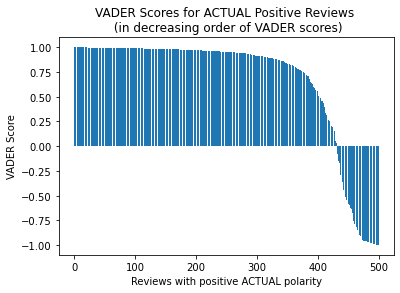

In [17]:
import matplotlib.pyplot as plt

pos_reviews_scored = VADER_polarity_test_df[:500]['VADER Score']
plt.bar(range(0, 500), pos_reviews_scored.sort_values(ascending=False))
plt.xlabel("Reviews with positive ACTUAL polarity")
plt.ylabel("VADER Score")
plt.title("VADER Scores for ACTUAL Positive Reviews \n (in decreasing order of VADER scores)")
plt.show()

Now, have a look at VADER scores assigned to actual negative reviews:

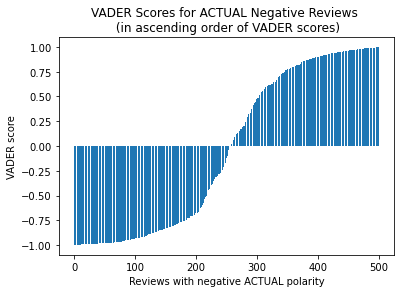

In [18]:
neg_reviews_scored = VADER_polarity_test_df[500:1000]['VADER Score']
plt.bar(range(0, 500), neg_reviews_scored.sort_values(ascending=True))
plt.xlabel("Reviews with negative ACTUAL polarity")
plt.ylabel("VADER score")
plt.title("VADER Scores for ACTUAL Negative Reviews \n (in ascending order of VADER scores)")
plt.show()

### **<font color=green>EXERCISE 2:</font>**

**<font color=green>2.1. Given the information in the confusion matrix, the computed precision and recall rates, as well as the plots above, is the VADER lexicon-based tool good at identifying positive reviews? What about negative reviews? Support your answer using information provided by plot and the statistics computed earlier. </font>**

Your answer:

The VADER lexicon-based tool in this case is better at identifying positive reviews than at negative ones. To be more specific, about 80% of the positive reviews are correctly identified while for the negative ones, it's only about 60%.

Can we **increase the accuracy rate** of our VADER lexicon-based tool? 

We can fine-tune it by **adjusting the threshold parameter** for defining positive polarity that we earlier set to 0.1. We'll be looking for the threshold value that gives us the **highest accuracy rate**.

Define a **function** that computes accuracy rate for different value of the threshold and call that function **try_threshold_for_accuracy**. The function will take the VADER score and the threshold parameter as inputs and return the accuracy rate, associated with the inputs:

In [19]:
def try_threshold_for_accuracy(sentiment_scores, threshold_for_pos):
    VADER_binary_polarity = ['positive' if s >= threshold_for_pos else 'negative' for s in list(sentiment_scores)]
    accuracy = metrics.accuracy_score(test_polarity, VADER_binary_polarity)
    return(accuracy) 

Let's apply this function to score the movie reviews using the threshold value = 0.5:

In [20]:
threshold = 0.5
print("Accuracy rate: ", try_threshold_for_accuracy(VADER_polarity_test_df['VADER Score'],threshold))

Accuracy rate:  0.707


Now, let's explore the changes in accuracy rate for a range of thresholds from -1 to 1 (that is VADER score's range):

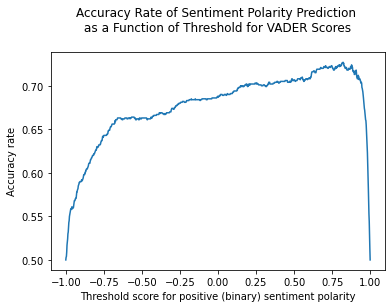

In [21]:
thresholds = np.linspace(-1,1,1000)
acc_rates = [try_threshold_for_accuracy(VADER_polarity_test_df['VADER Score'],threshold) for threshold in thresholds]

plt.plot(thresholds, acc_rates)
plt.xlabel("Threshold score for positive (binary) sentiment polarity")
plt.ylabel("Accuracy rate")
plt.title("Accuracy Rate of Sentiment Polarity Prediction \n as a Function of Threshold for VADER Scores \n")
plt.show()

### **<font color=green>EXERCISE 3:</font>**

**<font color=green>3.1. What is the threshold value that maximizes the prediction accuracy rate? Use the plot above to give an approximate value or use the Python line: thresholds[acc_rates.index(max(acc_rates))] to provide your answer. Why is this threshold value relatively high? </font>**

**<font color=green>3.2. What is the threshold value that maximizes the precision of the prediction? What about the recall? (HINT: You do not need to code up anything to answer this question)</font>**

**Your answer for 3.1:**

Code (if needed):

In [22]:
thresholds[acc_rates.index(max(acc_rates))]

0.8218218218218218

Discussion:

Thresholds of 0.82 yields highest accuracy rate.
With higher threshold, less reviews will be identified as positive, and thus can help to decrease the rate of false positive results(type I error).

**Your answer for 3.2:**

Discussion:

For precision, we focus on how many of the reviews are actually positive in what we identify as "positive" (minimize false positive). TO maximize it, we need to less the predicted positives so that only few of the reviews are mislabled. Thus, we use 1 (or very close to 1 as the treshold.

For the recall, we need to know in the actual "positive" reviews, we successfully identify how many of them. In this case, if we identify as many as reviews as positive, we won't miss any one of them, so we just set the threshold to -1.

### Training your Own Sentiment Classifier (Supervised Machine Learning)

Given that we have **labels** in the data, we can take advantage of them and train our own **sentiment classifier**. Let's do it and see if the performance of the custom classifier would be better than of the lexicon-based model above.

Start by vectorizing the normalized training dataset. Let's use TF-IDF approach and use a mix of **uni-grams** and **bi-grams** as features:

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range = (1,2)) 
feature_matrix_TRAIN = vectorizer.fit_transform(normalized_train_reviews).astype(float)

Have a look at the feature matrix with unigrams and bi-grams for the training data and note the n-grams:

In [30]:
feature_matrix_TRAIN_names = vectorizer.get_feature_names() 
feature_matrix_TRAIN_table = pd.DataFrame(data = feature_matrix_TRAIN.todense(), 
                                          columns = feature_matrix_TRAIN_names)
feature_matrix_TRAIN_table.head()

,00pm,00pm castro,00pm us,100m,100m budget,100th,100th grade,13th,13th film,13th part,...,zorro,zorro hell,zsigmond,zsigmond future,zu,zu neuen,zu warrior,zu xian,zumhofe,zumhofe look
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Vectorize **test data** using the features created based on the training data:

In [31]:
feature_matrix_TEST = vectorizer.transform(normalized_test_reviews)

Let's use Support Vector Machines (SVM) to train our custom sentiment classifier:

In [32]:
from sklearn import linear_model

svm = linear_model.SGDClassifier(loss='hinge', random_state = 0) 
svm.fit(feature_matrix_TRAIN, train_polarity)
predicted_svm = svm.predict(feature_matrix_TEST)

Compute the accuracy rate for the classifier:

In [33]:
print('Accuracy rate:', np.round(metrics.accuracy_score(test_polarity, predicted_svm), 3))

Accuracy rate: 0.798


Have a look at a sample of reviews and their predicted and actual sentiment:

In [34]:
sample_ids = [0, 30, 330, 855, 951, 995] 
for doc_index in sample_ids:
    print('Review:-')
    print(test_reviews[doc_index])
    print('\nActual Labeled Sentiment:', test_polarity[doc_index])
    print('Predicted Sentiment:', predicted_svm[doc_index])   
    print('-'*60)

Review:-
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.

Actual Labeled Sentiment: positive
Predicted Sentiment: positive
------------------------------------------------------------
Review:-
If you have not seen this late 80s film about the the Washin

### **<font color=green>EXERCISE 4:</font>**

**<font color=green>4.1. What explains the difference in the performance of the lexicon-based and the the SVM-based sentiment classifier, in your opinion?</font>**

**<font color=green>4.2. Suggest another sentiment classifier (you can consider a different approach to feature engineering or model training, or both) and compare its performance to the SVM-based sentiment classifier.</font>**

**Your answer for 4.1:**

With lexicon-based classifier, we can manually set the tresholds for the classifier, but for the SVM method, we can let the SVM do the work.

**Your answer for 4.2:**

Code:

In [54]:
vectorizer2 = TfidfVectorizer(ngram_range = (1,4)) 
feature_matrix_TRAIN2 = vectorizer2.fit_transform(normalized_train_reviews).astype(float)

feature_matrix_TRAIN_names2 = vectorizer2.get_feature_names() 
feature_matrix_TRAIN_table2 = pd.DataFrame(data = feature_matrix_TRAIN2.todense(), 
                                          columns = feature_matrix_TRAIN_names2)


feature_matrix_TEST2 = vectorizer2.transform(normalized_test_reviews)

svm.fit(feature_matrix_TRAIN2, train_polarity)
predicted_svm2 = svm.predict(feature_matrix_TEST2)

print('Accuracy rate:', np.round(metrics.accuracy_score(test_polarity, predicted_svm2), 3))

Accuracy rate: 0.799


Discussion:

In [56]:
By modifying the ngram to 1-4, the accuracy rate increases a little bit.